In [1]:
%matplotlib inline

In [2]:
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=gpu0,floatX=float32" 

import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 80.0% of memory, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5110, 6021))
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



In [10]:
import matplotlib.pyplot as plt

In [3]:
from keras import backend as K
import os

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("theano")

Using TensorFlow backend.
Using Theano backend.


# Vanilla Autoencoder

### Autoencoder architecture

In [34]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [35]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [36]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Compile the architecture with optimizer and loss function

In [7]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


### Train with MNIST dataset

In [10]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 0.2801 - val_loss: 0.2185
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 0.1979 - val_loss: 0.1808
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 0.1723 - val_loss: 0.1619
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 0.1566 - val_loss: 0.1486
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 0.1450 - val_loss: 0.1387
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 0.1364 - val_loss: 0.1310
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 0.1296 - val_loss: 0.1249
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 0.1239 - val_loss: 0.1198
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 0.1190 - val_loss: 0.1151
Epoch 10/50
60000/60000 [==============================] - 0s - loss: 0.1149 - val_loss: 0.1114

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

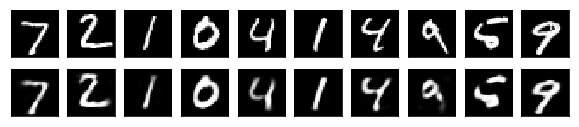

In [13]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

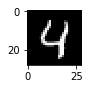

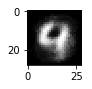

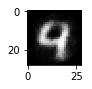

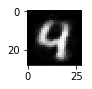

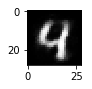

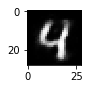

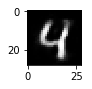

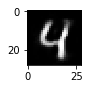

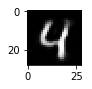

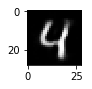

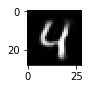

In [37]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
plt.figure(figsize = (1,1))
plt.imshow(x_test[4].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()
for it in range(10):
    autoencoder.fit(x_train, x_train,
                    epochs=2,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test, x_test),verbose = 0)
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    plt.figure(figsize = (1,1))
    plt.imshow(decoded_imgs[4].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

# Denoising autoencoder

In [38]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

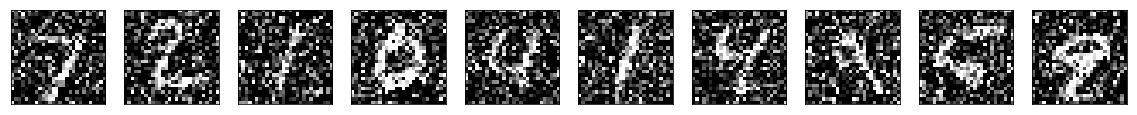

In [16]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [43]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [21]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 40s - loss: 0.2080 - val_loss: 0.1325
Epoch 2/100
60000/60000 [==============================] - 40s - loss: 0.1259 - val_loss: 0.1169
Epoch 3/100
60000/60000 [==============================] - 41s - loss: 0.1164 - val_loss: 0.1124
Epoch 4/100
60000/60000 [==============================] - 40s - loss: 0.1117 - val_loss: 0.1081
Epoch 5/100
60000/60000 [==============================] - 41s - loss: 0.1088 - val_loss: 0.1063
Epoch 6/100
60000/60000 [==============================] - 41s - loss: 0.1068 - val_loss: 0.1043
Epoch 7/100
60000/60000 [==============================] - 41s - loss: 0.1055 - val_loss: 0.1041
Epoch 8/100
60000/60000 [==============================] - 41s - loss: 0.1044 - val_loss: 0.1022
Epoch 9/100
60000/60000 [==============================] - 41s - loss: 0.1036 - val_loss: 0.1021
Epoch 10/100
60000/60000 [==============================] - 41s - loss: 0.102

KeyboardInterrupt: 

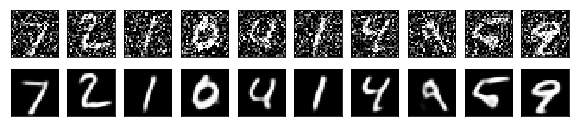

In [24]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(10, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()